In [24]:
from z3 import *

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image

from av_goal_recognition.goal_recognition import HandcraftedGoalTrees, TrainedDecisionTrees
from av_goal_recognition.verification import add_goal_tree_model
from av_goal_recognition.data_processing import get_dataset

## Handcrafted goal tree

In [4]:
scenario_name = 'heckstrasse'
model = HandcraftedGoalTrees.load(scenario_name)
reachable_goals = [(1, 'straight-on'), (2, 'turn-left')]

s = Solver()

features, probs = add_goal_tree_model(reachable_goals, s, model)

# unsatisfiable if G2 always has highest prob
verify_expr = Implies(And(features[1]['in_correct_lane'], Not(features[2]['in_correct_lane'])), probs[2] < probs[1])
s.add(Not(verify_expr))

print(s.check())


Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1770767: Lanelet has not exactly one left border!
	- Error parsing primitive -1770767: Lanelet has not exactly one right border!
	- Error parsing primitive -1770766: Lanelet has not exactly one left border!
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770573
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770492
	- Error parsing primitive -1770787: Areas must have exactly one outer ring!
unsat


verified true:
If car is in correct lane for G1, then G1 is predicted

In [10]:
scenario_name = 'heckstrasse'
model = HandcraftedGoalTrees.load(scenario_name)
reachable_goals = [(1, 'straight-on'), (2, 'turn-left')]

s = Solver()

features, probs = add_goal_tree_model(reachable_goals, s, model)

verify_expr = Implies(And(Not(features[1]['in_correct_lane']),
                          features[2]['in_correct_lane']), probs[2] > probs[1])
s.add(Not(verify_expr))

print(s.check())

Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1770767: Lanelet has not exactly one left border!
	- Error parsing primitive -1770767: Lanelet has not exactly one right border!
	- Error parsing primitive -1770766: Lanelet has not exactly one left border!
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770573
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770492
	- Error parsing primitive -1770787: Areas must have exactly one outer ring!
unsat


Verified true:
If car is in correct lane for G2, G2 is predicted


# Trained goal tree

In [13]:
scenario_name = 'heckstrasse'
model = TrainedDecisionTrees.load(scenario_name)
reachable_goals = [(1, 'straight-on'), (2, 'turn-left')]

s = Solver()

features, probs = add_goal_tree_model(reachable_goals, s, model)

verify_expr = Implies(And(features[1]['in_correct_lane'], Not(features[2]['in_correct_lane'])), probs[2] < probs[1])
s.add(Not(verify_expr))

print(s.check())

Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1770767: Lanelet has not exactly one left border!
	- Error parsing primitive -1770767: Lanelet has not exactly one right border!
	- Error parsing primitive -1770766: Lanelet has not exactly one left border!
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770573
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770492
	- Error parsing primitive -1770787: Areas must have exactly one outer ring!
sat


In [14]:
s.model()

[angle_in_lane_1 = 53966319188475609/50000000000000000,
 in_correct_lane_2 = False,
 2_turn-left = 42549575070821527/100000000000000000,
 angle_in_lane_2 = 5250531742349267/5000000000000000,
 1_straight-on = 7284587422233077/1000000000000000000,
 acceleration_2 = 3624239981174469/2000000000000000,
 in_correct_lane_1 = True]

Verification failed: If car is in correct lane for G1, then G1 is predicted.
Angle in lane > 0.08

## Investigate examples of this

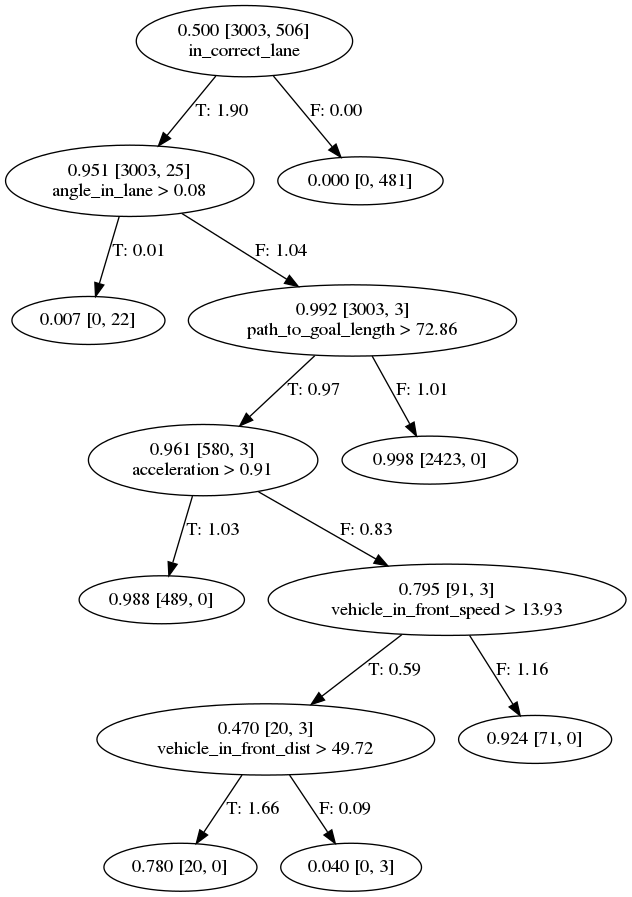

In [23]:
Image("../images/trained_tree_heckstrasse_G1_straight-on.png")

In [25]:
dataset = get_dataset(scenario_name, 'train')

Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1770767: Lanelet has not exactly one left border!
	- Error parsing primitive -1770767: Lanelet has not exactly one right border!
	- Error parsing primitive -1770766: Lanelet has not exactly one left border!
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770573
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770492
	- Error parsing primitive -1770787: Areas must have exactly one outer ring!


In [36]:
dataset.loc[(dataset.in_correct_lane)  
            & (dataset.angle_in_lane > 0.08)
           & (dataset.possible_goal==1) & (dataset.goal_type=='straight-on')]

,path_to_goal_length,in_correct_lane,speed,acceleration,angle_in_lane,vehicle_in_front_dist,vehicle_in_front_speed,oncoming_vehicle_dist,goal_type,agent_id,possible_goal,true_goal,true_goal_type,frame_id,initial_frame_id,fraction_observed,episode
682,80.783259,True,10.63672,0.67458,0.086457,56.824550,14.20752,100.000000,straight-on,40,1,2,turn-left,3034,3034,0.0,0
684,72.947803,True,10.61505,-1.25203,0.097539,59.162766,13.99616,100.000000,straight-on,40,1,2,turn-left,3052,3034,0.1,0
700,47.019043,True,2.67183,1.33927,1.363614,34.310718,14.13040,1.771175,straight-on,40,1,2,turn-left,3196,3034,0.9,0
702,45.180632,True,4.07726,1.71893,1.544435,43.046940,14.36721,100.000000,straight-on,40,1,2,turn-left,3214,3034,1.0,0
2425,49.077375,True,5.49852,0.02116,1.559350,15.972673,14.62199,-0.392293,straight-on,114,1,2,turn-left,8297,8187,1.0,0
3291,48.920688,True,6.38365,-0.27956,1.542793,21.629012,6.70308,-0.113370,straight-on,152,1,2,turn-left,10811,10711,1.0,0
3941,48.619220,True,5.74710,0.29423,1.529722,22.154820,15.00663,-0.439802,straight-on,178,1,2,turn-left,12313,12203,1.0,0
3985,49.077375,True,6.12863,0.01382,1.534518,49.946007,15.07693,-1.349706,straight-on,180,1,2,turn-left,12358,12248,1.0,0
4215,45.180632,True,5.17451,1.64664,1.419771,25.534468,10.56990,100.000000,straight-on,190,1,2,turn-left,14282,13312,1.0,0
285,48.631564,True,5.37056,1.45189,1.519772,6.896709,12.24145,-0.515360,straight-on,39,1,2,turn-left,1730,1500,1.0,1


In [15]:
scenario_name = 'heckstrasse'
model = TrainedDecisionTrees.load(scenario_name)
reachable_goals = [(1, 'straight-on'), (2, 'turn-left')]

s = Solver()

features, probs = add_goal_tree_model(reachable_goals, s, model)


verify_expr = Implies(And(Not(features[1]['in_correct_lane']), features[2]['in_correct_lane']), probs[2] > probs[1])
s.add(Not(verify_expr))

print(s.check())

Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1770767: Lanelet has not exactly one left border!
	- Error parsing primitive -1770767: Lanelet has not exactly one right border!
	- Error parsing primitive -1770766: Lanelet has not exactly one left border!
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770573
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770492
	- Error parsing primitive -1770787: Areas must have exactly one outer ring!
unsat


Verified true: If car is in correct lane for G2, G2 is predicted